In [19]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt

import kagglehub

In [20]:

# Download latest version
path = kagglehub.dataset_download("faviovaz/marketing-ab-testing")

df = pd.read_csv(path + '/marketing_AB.csv')

In [21]:
df.rename(columns={'Unnamed: 0': 'index'}, inplace=True)

In [22]:
df.set_index('index', inplace=True)

In [23]:
df['converted'].value_counts()

converted
False    573258
True      14843
Name: count, dtype: int64

In [24]:
# 1. Group and aggregate
results = df.groupby('test group')['converted'].agg(['sum', 'count'])

# 2. Calculate rate and round in one line
results['conversion_rate'] = (results['sum'] / results['count'] * 100).round(2)

# 3. Optional: Rename for the "Business Innovation" vibe
results.columns = ['Conversions', 'Total', 'Rate (%)']

results

,Conversions,Total,Rate (%)
test group,,,
ad,14423,564577,2.55
psa,420,23524,1.79


In [25]:
df_ad = df[df['test group'] == 'ad'].copy()
df_ad.head()

,user id,test group,converted,total ads,most ads day,most ads hour
index,,,,,,
0,1069124,ad,False,130,Monday,20
1,1119715,ad,False,93,Tuesday,22
2,1144181,ad,False,21,Tuesday,18
3,1435133,ad,False,355,Tuesday,10
4,1015700,ad,False,276,Friday,14


In [26]:
df_ad.groupby('most ads day')['converted'].agg(['sum', 'count'])

,sum,count
most ads day,,
Friday,1995,88805
Monday,2778,83571
Saturday,1679,78802
Sunday,2027,82332
Thursday,1711,79077
Tuesday,2270,74572
Wednesday,1963,77418


In [27]:
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
pivot_report = df_ad.pivot_table(
    index='most ads day',
    columns='most ads hour',
    values='converted',
    aggfunc='mean'
).round(2).reindex(day_order)
pivot_report

most ads hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
most ads day,,,,,,,,,,,,,,,,,,,,,
Monday,0.02,0.02,0.01,0.01,0.00,0.03,0.04,0.02,0.03,0.03,...,0.04,0.04,0.04,0.04,0.03,0.03,0.03,0.03,0.03,0.02
Tuesday,0.02,0.01,0.01,0.02,0.02,0.01,0.02,0.02,0.02,0.02,...,0.04,0.04,0.05,0.04,0.04,0.03,0.03,0.02,0.03,0.03
Wednesday,0.01,0.01,0.00,0.00,0.02,0.01,0.01,0.01,0.02,0.02,...,0.03,0.03,0.04,0.03,0.03,0.02,0.03,0.03,0.03,0.02
Thursday,0.03,0.02,0.01,0.01,0.03,0.02,0.02,0.02,0.02,0.02,...,0.03,0.02,0.03,0.02,0.02,0.02,0.03,0.02,0.02,0.02
Friday,0.02,0.01,0.01,0.00,0.02,0.02,0.01,0.02,0.02,0.02,...,0.02,0.03,0.03,0.02,0.02,0.02,0.03,0.03,0.02,0.02
Saturday,0.02,0.01,0.00,0.01,0.00,0.06,0.05,0.02,0.02,0.02,...,0.02,0.02,0.02,0.02,0.03,0.03,0.02,0.03,0.03,0.02
Sunday,0.02,0.02,0.01,0.02,0.02,0.02,0.01,0.02,0.02,0.02,...,0.02,0.02,0.03,0.03,0.03,0.04,0.04,0.04,0.03,0.03


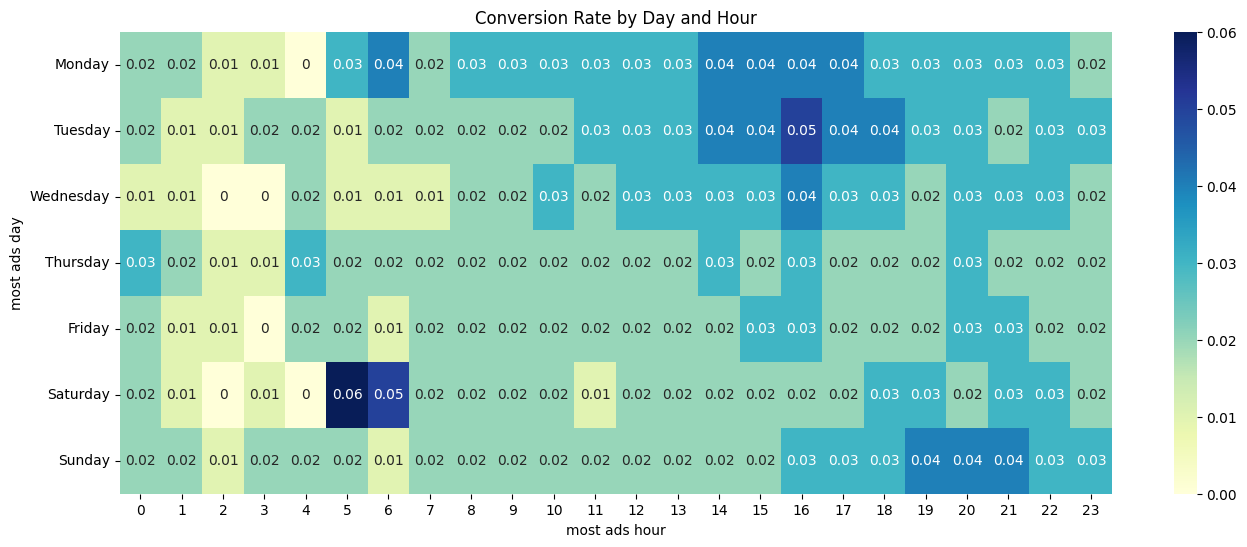

In [28]:
plt.figure(figsize=(16,6))
sns.heatmap(pivot_report, annot=True, cmap='YlGnBu')
plt.title('Conversion Rate by Day and Hour')
plt.show()

In [29]:
summary = df_ad.groupby(['most ads day', 'most ads hour'])['converted'].agg(['sum', 'count'])
summary = summary.reindex(day_order, level=0)
summary.xs('Saturday', level='most ads day', drop_level=False)

sum  count
most ads day most ads hour            
Saturday     0               18    763
             1                7    819
             2                4    900
             3                4    362
             4                0     79
             5                5     88
             6               13    252
             7               17    727
             8               50   2150
             9               60   3645
             10              79   4867
             11              84   5760
             12             108   5852
             13             121   6056
             14             118   5849
             15             128   5869
             16             104   5223
             17             109   4850
             18             112   4368
             19             119   4445
             20             111   4593
             21             146   4542
             22              99   3904
             23              63   2839

### Saturday's conversion rate at 5-6 am is around 6%. Looking at the data we can see that this % is mostly noise as in total 18 people were converted out of 340 for both hours. Our dataset is huge so we can expect the conversion rate to regress to the mean if more poeple were to be reached.

In [30]:
df_ad['ad_bins'] = pd.cut(df_ad['total ads'], bins=[0,5,10,20,50,100,1000])

fatigue_analysis = df_ad.groupby('ad_bins')['converted'].agg(['mean', 'count'])
fatigue_analysis['mean'] = (fatigue_analysis['mean'] * 100).round(2)

fatigue_analysis

/var/folders/ht/sgl2f_ln6_x_z9swpz2ktyf80000gn/T/ipykernel_10370/2119653175.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fatigue_analysis = df_ad.groupby('ad_bins')['converted'].agg(['mean', 'count'])


,mean,count
ad_bins,,
"(0, 5]",0.25,169962
"(5, 10]",0.49,79537
"(10, 20]",0.84,123334
"(20, 50]",2.92,125541
"(50, 100]",11.63,44149
"(100, 1000]",17.13,22018


In [31]:
df_psa = df[df['test group'] == 'psa'].copy()

df_psa['ad_bins'] = pd.cut(df_psa['total ads'], bins=[0,5,10,20,50,100,1000])

psa_analysis = df_psa.groupby('ad_bins')['converted'].agg(['mean', 'count'])
psa_analysis['mean'] = (psa_analysis['mean'] * 100).round(2)

fatigue_analysis.columns = ['Ad_Rate', 'Ad_Count']
psa_analysis.columns = ['PSA_Rate', 'PSA_Count']

comparison = pd.concat([fatigue_analysis['Ad_Rate'], psa_analysis['PSA_Rate']], axis=1)
comparison

/var/folders/ht/sgl2f_ln6_x_z9swpz2ktyf80000gn/T/ipykernel_10370/2207391756.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  psa_analysis = df_psa.groupby('ad_bins')['converted'].agg(['mean', 'count'])


,Ad_Rate,PSA_Rate
ad_bins,,
"(0, 5]",0.25,0.28
"(5, 10]",0.49,0.67
"(10, 20]",0.84,0.82
"(20, 50]",2.92,2.18
"(50, 100]",11.63,5.77
"(100, 1000]",17.13,11.88


### We have a massive activity bias here. The people seeing 100+ ads are just heavy users who were going to convert at 11% anyway as we see in the PSA group. However, the ads do provide a significant plus on top of that—pushing them from ~12% to ~17%. The ads work, but they are not the only reason these people are buying.

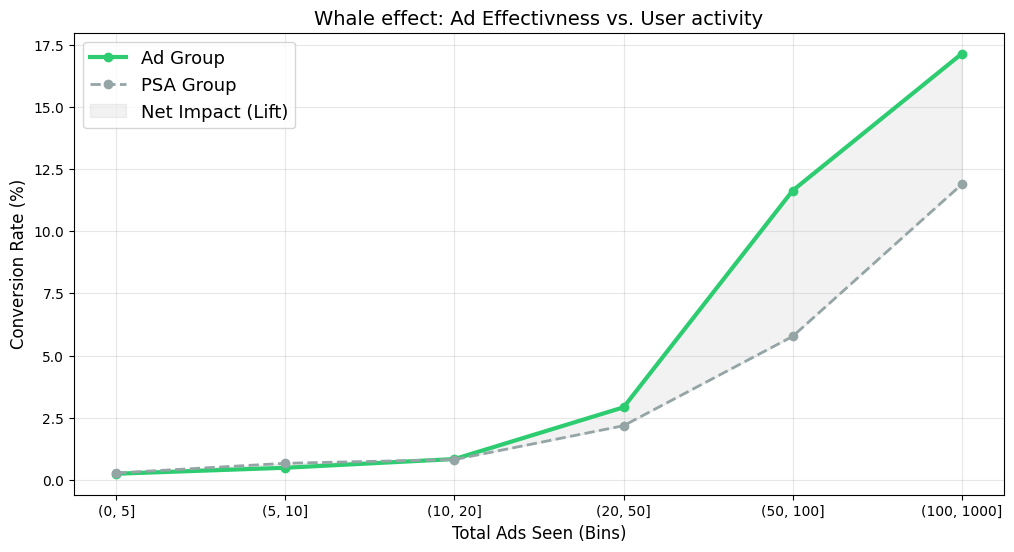

In [32]:
plt.figure(figsize=(12,6))

plt.plot(comparison.index.astype(str), comparison['Ad_Rate'],
marker='o', color='#2ecc71', linewidth=3, label = 'Ad Group')

plt.plot(comparison.index.astype(str), comparison['PSA_Rate'],
marker='o', color='#95a5a6', linestyle='--', linewidth=2, label = 'PSA Group')

plt.fill_between(comparison.index.astype(str),
comparison['Ad_Rate'],
comparison['PSA_Rate'],
color='grey', alpha=0.1, label='Net Impact (Lift)')

plt.title('Whale effect: Ad Effectivness vs. User activity', fontsize=14)
plt.ylabel('Conversion Rate (%)', fontsize=12)
plt.xlabel('Total Ads Seen (Bins)', fontsize=12)
plt.legend(fontsize=13)
plt.grid(True, alpha=0.3)
plt.show()

In [33]:
ad_rate_100 = comparison.iloc[-1]['Ad_Rate']
psa_rate_100 = comparison.iloc[-1]['PSA_Rate']

lift_100 = ((ad_rate_100 - psa_rate_100) / psa_rate_100 * 100).round(2)

print(f"Lift at 100+ ads: {lift_100}%")

Lift at 100+ ads: 44.19%


### At 100+ Ads, displaying ads to high-activity users drives a 44% increase in conversions compared to the natural baseline.